In [1]:
import pandas as pd
import numpy as np
from fco2models.utraining import prepare_segment_ds, prep_df
val_df = pd.read_parquet('../data/training_data/valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet('../data/training_data/df_100km_xco2_2021.pq')
train_df = pd.read_parquet('../data/training_data/traindf_100km_xco2.pq')

train_df, val_df, val_df2021 = prep_df([train_df, val_df, val_df2021], bound=True, index=['segment', 'bin'])


2025-04-29 15:06:19,673 - INFO - salinity stacking
2025-04-29 15:06:20,955 - INFO - adding positional and temporal encodings
2025-04-29 15:06:26,059 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-29 15:06:26,269 - INFO - clipping fco2rec_uatm to 5th and 95th percentiles
2025-04-29 15:06:28,723 - INFO - salinity stacking
2025-04-29 15:06:28,818 - INFO - adding positional and temporal encodings
2025-04-29 15:06:29,458 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-29 15:06:29,569 - INFO - clipping fco2rec_uatm to 5th and 95th percentiles
2025-04-29 15:06:29,791 - INFO - salinity stacking
2025-04-29 15:06:29,862 - INFO - adding positional and temporal encodings
2025-04-29 15:06:30,108 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-29 15:06:30,162 - INFO - clipping fco2rec_uatm to 5th and 95th percentiles


In [2]:
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import MLP, UNet2DModelWrapper
import torch
import json
from fco2models.ueval import load_model

# load model
save_path = '../models/renko/xco2_corrected/'
model_path = 'e_60.pt'
model_class = UNet2DModelWrapper


model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Model loaded")

Model loaded


In [4]:
from fco2models.utraining import prepare_segment_ds, normalize_dss, get_stats
predictors = params['predictors']
train_ds, val_ds = prepare_segment_ds([train_df, val_df], predictors)
train_stats = get_stats(train_ds)
train_ds, val_ds = normalize_dss([train_ds, val_ds], train_stats, params['mode'], ignore=[7,8,9])
stats = {'train_means': train_stats['means'], 
         'train_stds': train_stats['stds'],
         'train_mins': train_stats['mins'], 
         'train_maxs': train_stats['maxs']
         }
# vald_ds2021 = prep_data(vald_df2021, predictors)
# val_ds = np.concatenate((val_ds, vald_ds2021), axis=0)

print("train_ds shape: ", train_ds.shape)
print("val_ds shape: ", val_ds.shape)

2025-04-29 17:04:23,547 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'day_of_year', 'lat', 'lon']


Number of samples after filtering:  209343
yX shape: (10, 209343, 64)


2025-04-29 17:04:28,192 - INFO - add latitude feature
2025-04-29 17:04:28,586 - INFO - add longitude feature
2025-04-29 17:04:28,847 - INFO - add day of year feature
2025-04-29 17:04:31,574 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'day_of_year', 'lat', 'lon']


Number of samples after filtering:  22441
yX shape: (10, 22441, 64)


2025-04-29 17:04:31,963 - INFO - add latitude feature
2025-04-29 17:04:32,009 - INFO - add longitude feature
2025-04-29 17:04:32,052 - INFO - add day of year feature
2025-04-29 17:04:36,440 - INFO - Means: [np.float64(-30.14823839348501), np.float64(291.49492360826207), np.float64(32.558164963890555), np.float64(0.6836796394383253), np.float64(0.05670852774367465), np.float64(37.11385439700527), np.float64(392.4558850338762), np.float64(0.2808910699710706), np.float64(0.29618422022818564), np.float64(0.2734114969206367)]
2025-04-29 17:04:36,447 - INFO - Stds: [np.float64(42.3076553757995), np.float64(9.417746927771578), np.float64(7.516368452649472), np.float64(1.8752586802383828), np.float64(0.10902147425141874), np.float64(56.17053871096368), np.float64(13.507788179586058), np.float64(0.6489223426655204), np.float64(0.6420863708939949), np.float64(0.6521090041945565)]
2025-04-29 17:04:36,448 - INFO - Mins: [np.float64(-129.9781036376953), np.float64(271.1499938964844), np.float64(2.7

train_ds shape:  (209343, 10, 64)
val_ds shape:  (22441, 10, 64)


In [ ]:
train_losses = losses['train_losses']
val_losses = losses['val_losses']
# print epoch with minimum loss
print("Epoch with minimum training loss: ", np.argmin(train_losses))
print("Minimum training loss: ", np.min(train_losses))

val_losses_mean = np.mean(val_losses, axis=1)
print("Epoch with minimum validation loss: ", np.argmin(val_losses_mean))
print("Minimum validation loss: ", np.min(val_losses_mean))

Epoch with minimum training loss:  97
Minimum training loss:  0.040117167580809014
Epoch with minimum validation loss:  10
Minimum validation loss:  0.1353817118578511


In [5]:

np.random.shuffle(val_ds)
assert np.allclose(train_stats['maxs'], params['train_maxs'])
assert np.allclose(train_stats['mins'], params['train_mins'])
assert np.allclose(train_stats['means'], params['train_means'])
assert np.allclose(train_stats['stds'], params['train_stds'])


In [ ]:
n_rec = 5
n_samples = 1000

In [ ]:
from fco2models.utraining import full_denoise
from torch.utils.data import Dataset, DataLoader
import torch

val_context = val_ds[:n_samples, 1:, :]
val_context_ds = torch.from_numpy(np.repeat(val_context, n_rec, axis=0)).float()
print("context_ds shape: ", val_context_ds.shape)
val_context_loader = DataLoader(val_context_ds, batch_size=128, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    val_samples_norm = full_denoise(model, noise_scheduler, val_context_loader, jump=20)

context_ds shape:  torch.Size([500, 9, 64])
Denoising samples
Training on cuda


Inference: 100%|██████████| 4/4 [00:28<00:00,  7.17s/it, timestep=tensor(19)] 


In [ ]:
np.nanmean(val_samples_norm, axis=(0,2)),np.nanmean(val_ds[:, 0:1, :], axis=(0,2)), np.nanstd(val_samples_norm, axis=(0,2)), np.nanstd(val_ds[:, 0:1, :], axis=(0,2))

(array([0.15288888], dtype=float32),
 array([0.10760211]),
 array([0.4318258], dtype=float32),
 array([0.49778488]))

In [ ]:
train_context = train_ds[:n_samples, 1:, :]   
train_context_ds = torch.from_numpy(np.repeat(train_context, n_rec, axis=0)).float()
print("context_ds shape: ", train_context_ds.shape)
train_context_loader = DataLoader(train_context_ds, batch_size=128, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    train_samples_norm = full_denoise(model, noise_scheduler, train_context_loader, jump=20)

context_ds shape:  torch.Size([500, 9, 64])
Denoising samples
Training on cuda


Inference: 100%|██████████| 4/4 [00:20<00:00,  5.12s/it, timestep=tensor(19)] 


In [ ]:
from fco2models.ueval import get_error_stats
# get error stats for the training set
print("Training set error stats")
train_samples, train_ds_scaled = get_error_stats(
    train_samples_norm.reshape(n_samples, n_rec, 64), 
    train_ds[:n_samples, 0:1, :], 
    stats, 
    mode='min_max')

Training set error stats
Error statistics:
RMSE: 7.6791
MAE: 5.8515
R2: 0.5882
Mean correlation: 0.2095 ± 0.4258


In [ ]:
from fco2models.ueval import get_error_stats
# calculate the error statistics for the validation set
print("Validation set error stats")
val_samples, val_ds_scaled = get_error_stats(
    val_samples_norm.reshape(n_samples, n_rec, 64), 
    val_ds[:n_samples, 0:1, :], 
    stats, 
    mode='min_max')

C:\Users\henry\OneDrive\Desktop\OceanCO2_data-20250225T145156Z-001\dataset-exploration-main\src\fco2models\ueval.py:147: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(truth[i][~nan_mask], means[i][~nan_mask])


Validation set error stats
Error statistics:
RMSE: 18.4701
MAE: 12.1757
R2: 0.7916
Mean correlation: 0.3039 ± 0.4548


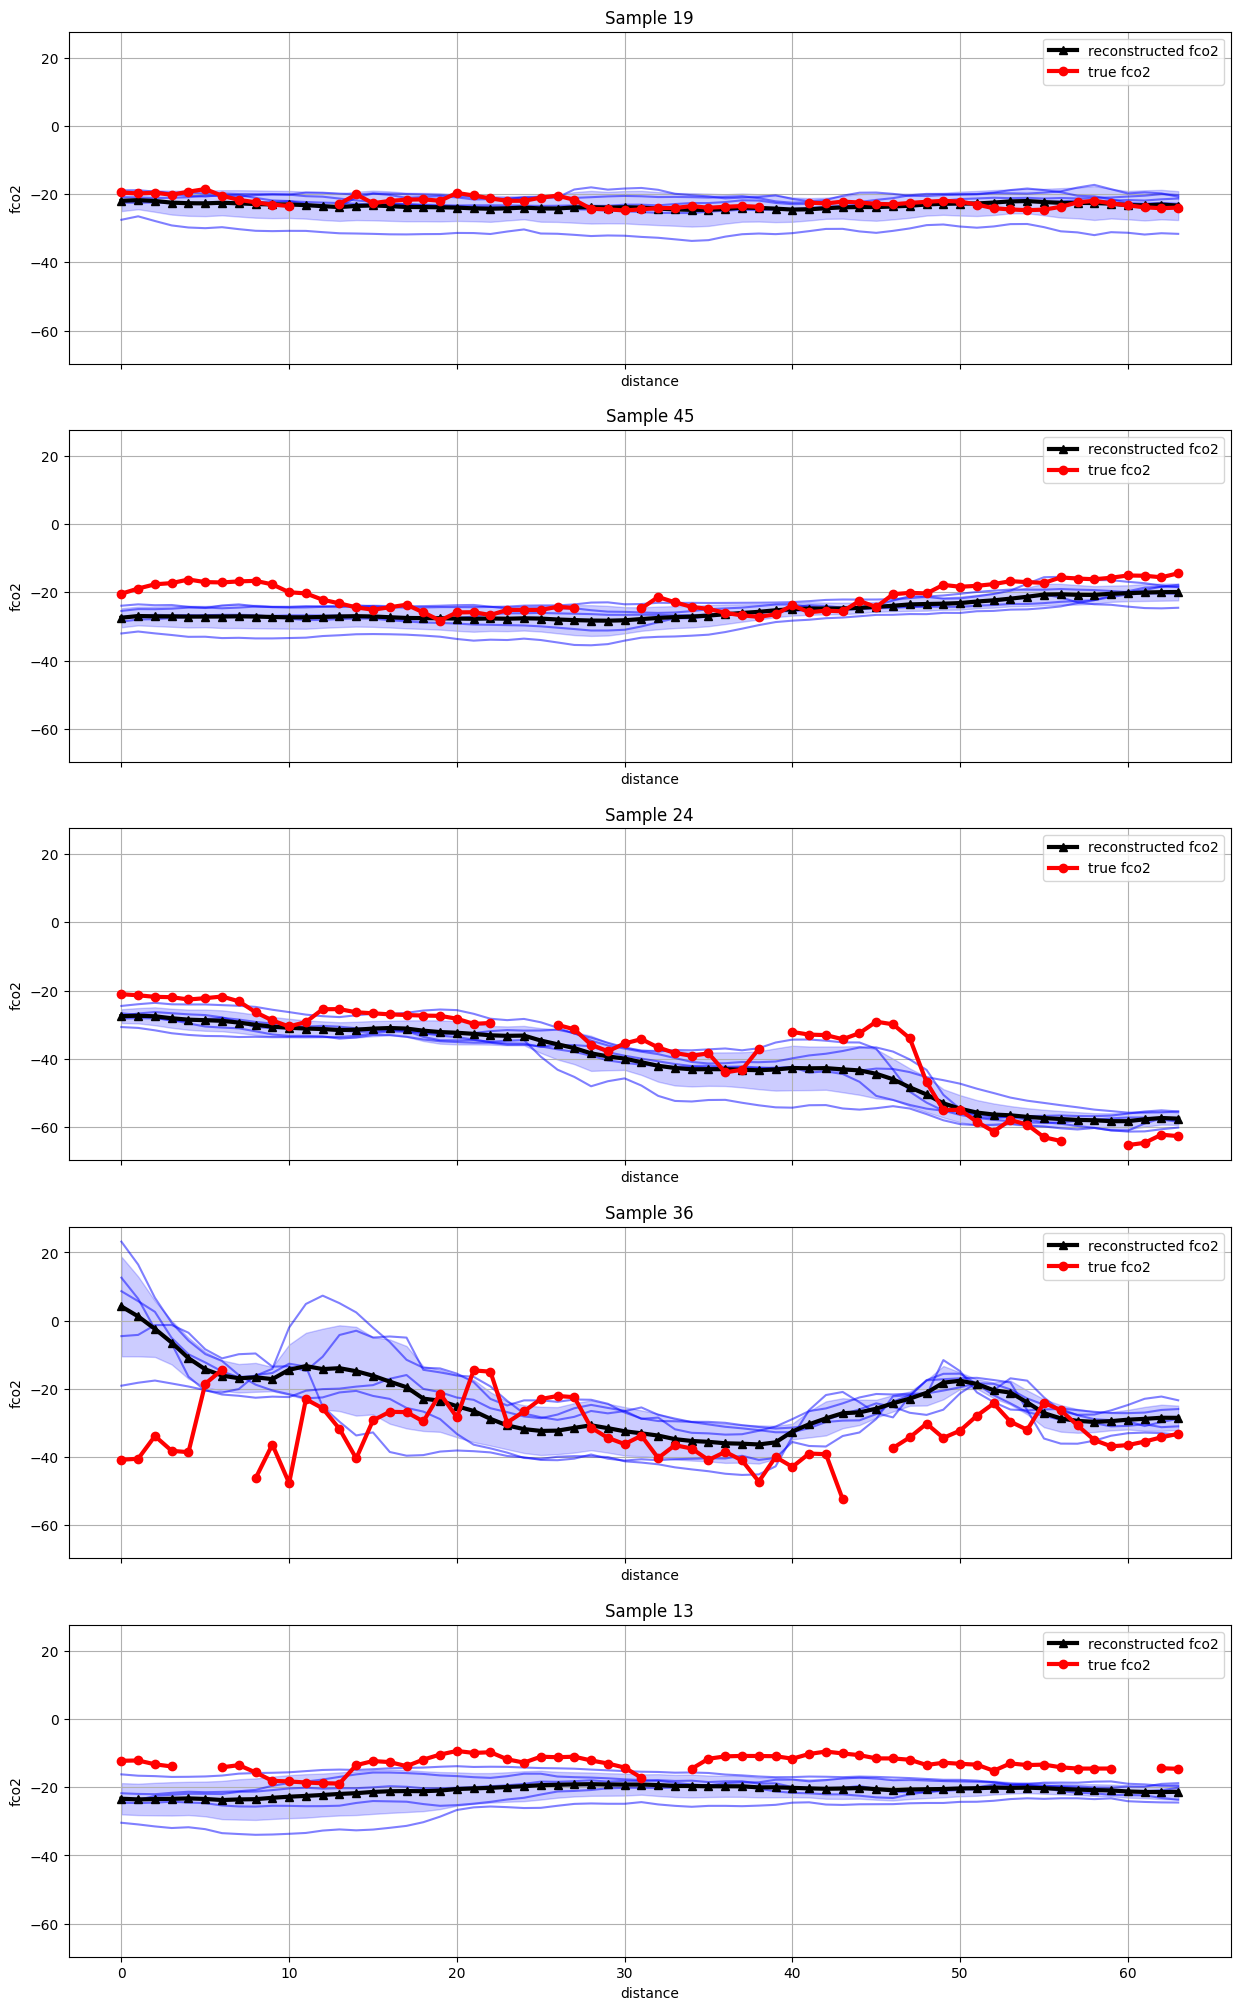

In [ ]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, n_samples), 5, replace=False)
fig, axs = plt.subplots(len(ixs), 1, figsize=(15, len(ixs)*5), sharex=True, sharey=True)
for i, ax in zip(ixs, axs):
    samples = train_samples[i, :, :]
    truth = train_ds_scaled[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

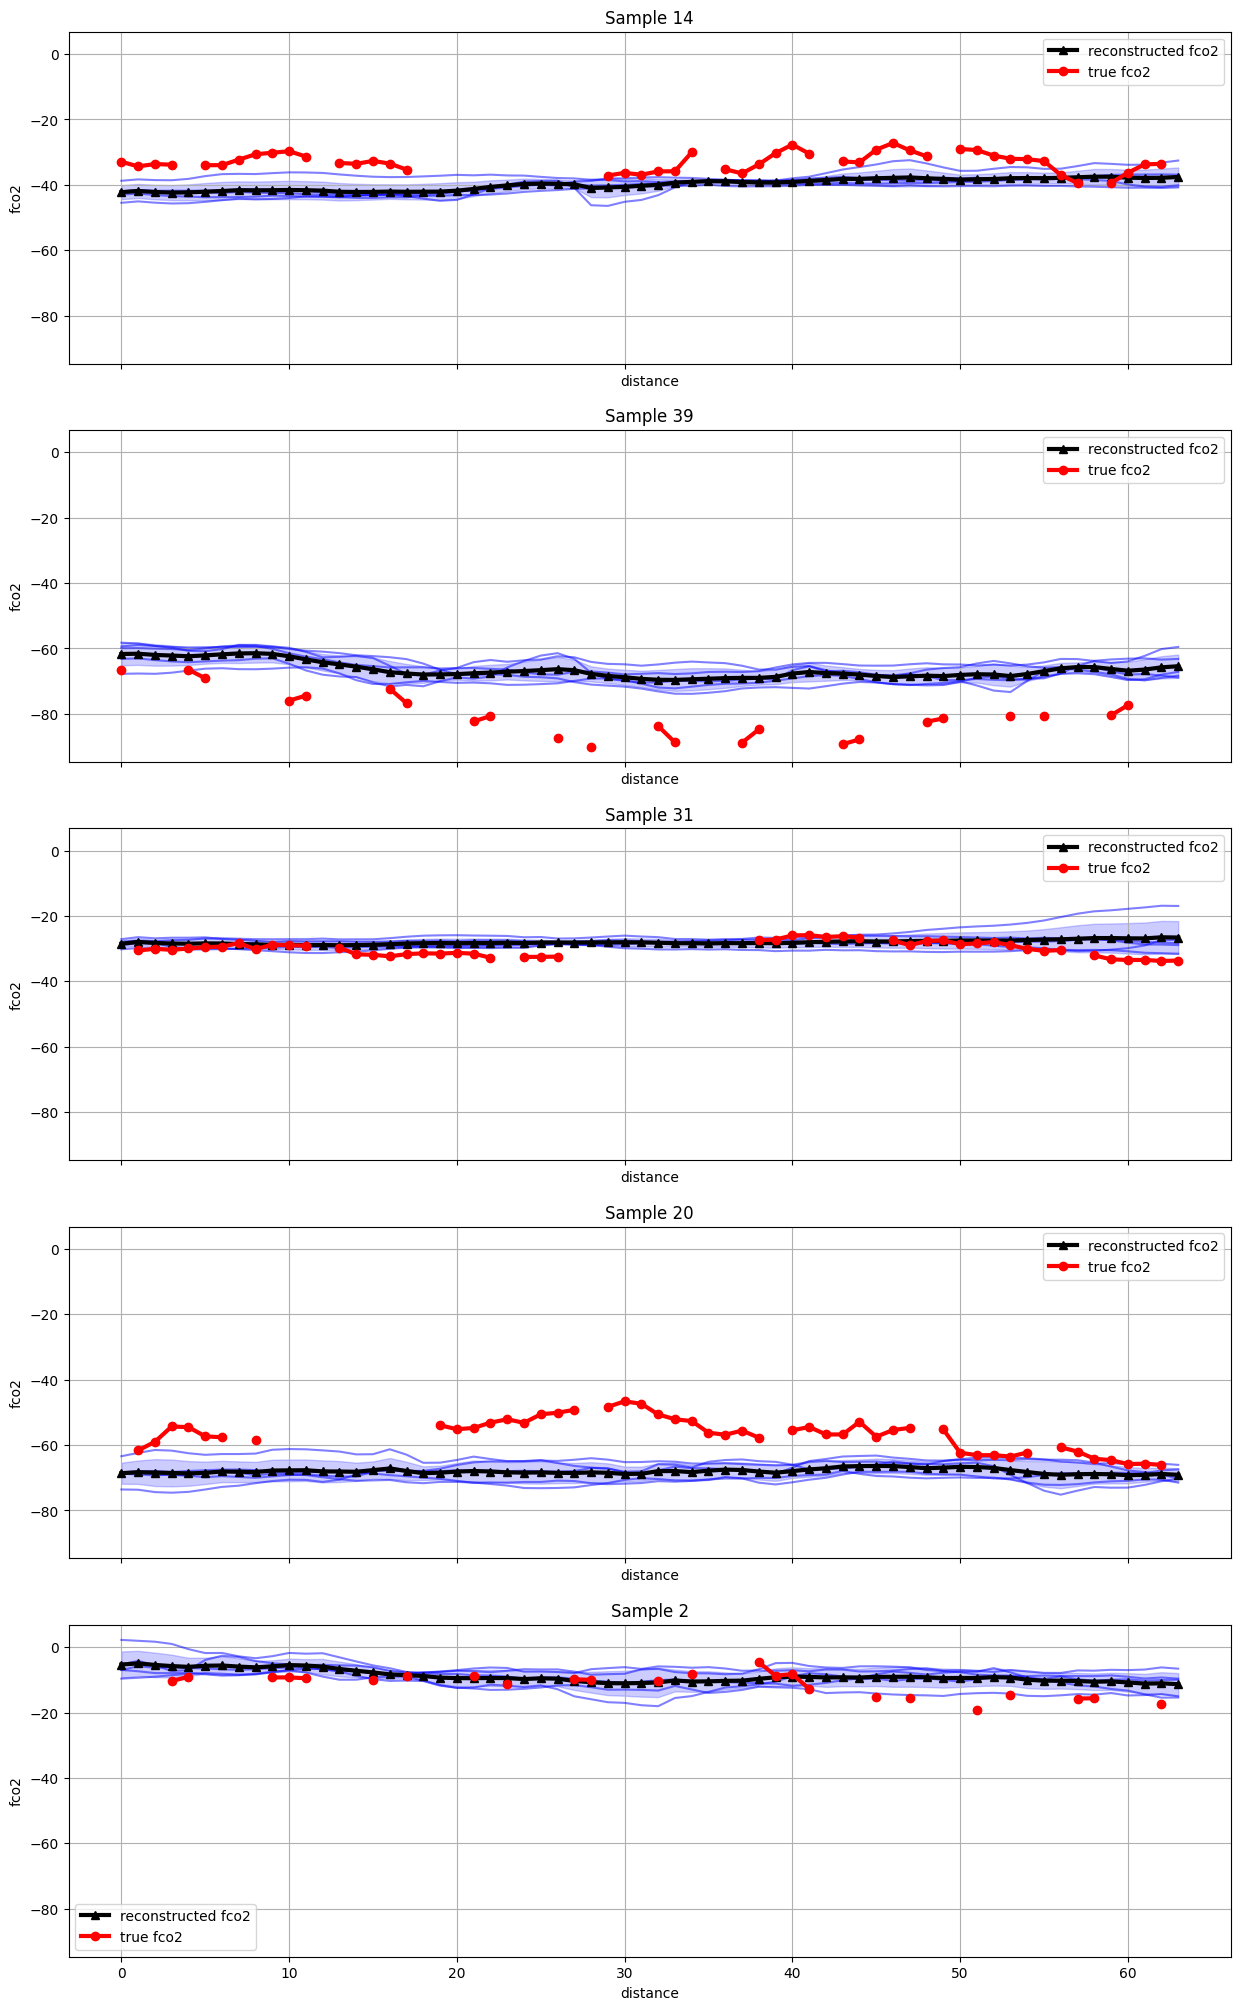

In [ ]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, 50), 5, replace=False)
fig, axs = plt.subplots(len(ixs), 1, figsize=(15, len(ixs)*5), sharex=True, sharey=True)
for i, ax in zip(ixs, axs):
    samples = val_samples[i, :, :]
    truth = val_ds_scaled[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

# analyse baseline model

In [109]:
import pandas as pd
import numpy as np
from fco2models.utraining import prepare_segment_ds, prep_df
val_df = pd.read_parquet('../data/training_data/valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet('../data/training_data/df_100km_xco2_2021.pq')
train_df = pd.read_parquet('../data/training_data/traindf_100km_xco2.pq')

In [110]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
import torch
import json
# load baseline model
save_path = '../models/baseline/unet1d/'
model_path = 'e_20.pt'
model_class = UNet1DModel
def load_model(save_dir, model_path, model_class):
    #read model hyperparameters
    with open(save_dir+'hyperparameters.json', 'r') as f:
        params = json.load(f)

    with open(save_dir+'losses.json', 'r') as f:
        losses = json.load(f)
    
    model_params = params['model_params']
    noise_params = params['noise_params']

    # load the model
    model = model_class(**model_params)
    model.load_state_dict(torch.load(save_dir+model_path))
    model.eval()

    noise_scheduler = None
    if noise_params is not None:
        noise_scheduler = DDPMScheduler(**noise_params)

    return model, noise_scheduler, params, losses
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Baseline model loaded")

Baseline model loaded


In [111]:
predictors = params['predictors']
print("Predictors: ", predictors)

train_df, val_df = prep_df([train_df, val_df], index=['segment', 'bin'])
train_ds_baseline, val_ds_baseline = prepare_segment_ds([train_df, val_df], predictors)
# val_ds_2021_baseline = prep_data(vald_df2021, predictors)
# val_ds_baseline = np.concatenate((val_ds_baseline, val_ds_2021_baseline), axis=0)
# train_ds_baseline = prepare_segment_ds([train_df], predictors)[0]
print("train_ds_baseline shape: ", train_ds_baseline.shape)
print("val_ds_baseline shape: ", val_ds_baseline.shape)

Predictors:  ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'lat', 'lon', 'day_of_year', 'xco2']


2025-04-28 13:57:55,980 - INFO - salinity stacking
2025-04-28 13:57:56,171 - INFO - adding positional and temporal encodings
2025-04-28 13:58:00,317 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-28 13:58:01,739 - INFO - salinity stacking
2025-04-28 13:58:01,771 - INFO - adding positional and temporal encodings
2025-04-28 13:58:02,121 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-04-28 13:58:04,711 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'lat', 'lon', 'day_of_year', 'xco2']


Number of samples after filtering:  209343
yX shape: (10, 209343, 64)


2025-04-28 13:58:09,911 - INFO - add latitude feature
2025-04-28 13:58:10,429 - INFO - add longitude feature
2025-04-28 13:58:10,730 - INFO - add day of year feature
2025-04-28 13:58:12,679 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'lat', 'lon', 'day_of_year', 'xco2']


Number of samples after filtering:  22441
yX shape: (10, 22441, 64)


2025-04-28 13:58:12,929 - INFO - add latitude feature
2025-04-28 13:58:12,983 - INFO - add longitude feature
2025-04-28 13:58:12,995 - INFO - add day of year feature


train_ds_baseline shape:  (209343, 10, 64)
val_ds_baseline shape:  (22441, 10, 64)


In [112]:
# normalize the data
train_maxs = params['train_maxs']
train_mins = params['train_mins']

for i in range(val_ds_baseline.shape[1]):
    val_ds_baseline[:, i, :] = 2 * (val_ds_baseline[:, i, :] - train_mins[i]) / (train_maxs[i] - train_mins[i]) - 1
    train_ds_baseline[:, i, :] = 2 * (train_ds_baseline[:, i, :] - train_mins[i]) / (train_maxs[i] - train_mins[i]) - 1
    # print max and min values
    print("Max value of predictor ", i, ": ", np.nanmax(val_ds_baseline[:, i, :]))
    print("Min value of predictor ", i, ": ", np.nanmin(val_ds_baseline[:, i, :]))

Max value of predictor  0 :  1.0163700856852897
Min value of predictor  0 :  -0.9100480247742586
Max value of predictor  1 :  0.9385515663265622
Min value of predictor  1 :  -0.9939803885722764
Max value of predictor  2 :  0.9894330785391408
Min value of predictor  2 :  -0.9714063957247426
Max value of predictor  3 :  0.6568312421999736
Min value of predictor  3 :  -0.9999623124466104
Max value of predictor  4 :  0.9341275105452267
Min value of predictor  4 :  -0.877784788884203
Max value of predictor  5 :  1.0553854168681975
Min value of predictor  5 :  -1.0
Max value of predictor  6 :  1.0
Min value of predictor  6 :  -1.0
Max value of predictor  7 :  1.0
Min value of predictor  7 :  -1.0
Max value of predictor  8 :  1.0
Min value of predictor  8 :  -1.0
Max value of predictor  9 :  0.9921846757673305
Min value of predictor  9 :  -0.8137395800717141


In [113]:
np.nanmean(train_ds_baseline[:, 0, :])

np.float64(-0.19311223830866928)

In [114]:
import tqdm

def baseline_eval_loop(model, val_dataloader, device, random_model=None):
    loss_fn = torch.nn.MSELoss(reduction='none')
    losses = []
    preds = []
    random_preds = []
    with torch.no_grad():
        for batch in tqdm.tqdm(val_dataloader):
            batch = batch.to(device)
            target = batch[:, 0:1, :]
            context = batch[:, 1:, :]
            nan_mask = torch.isnan(target)
            # replace nan with zeros
            target = torch.where(nan_mask, torch.zeros_like(target), target).float()
            #concatenate the noisy target with the context and the mask
            input = torch.cat([context, (~nan_mask).float()], dim=1)
            input = input.to(device).float()
            mean_pred = model(input, torch.zeros(batch.shape[0], ).to(device), return_dict=False)[0]
            # Calculate the loss
            loss = loss_fn(mean_pred[~nan_mask], target[~nan_mask])
            #val_loss += loss
            losses.append(loss.cpu().numpy())
            preds.append(mean_pred.cpu().numpy())
            if random_model is not None:
                # calculate random model prediction
                random_pred = random_model(input, torch.zeros(batch.shape[0], ).to(device), return_dict=False)[0]
                random_preds.append(random_pred.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    print("preds shape: ", preds.shape)
    losses = np.concatenate(losses, axis=0)
    print("losses shape: ", losses.shape)
    # random_preds = np.concatenate(random_preds, axis=0)
    # print("random_preds shape: ", random_preds.shape)
    return preds, losses, random_preds

In [121]:
# calculate average correlation coefficient
from scipy.stats import pearsonr
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
# import r2 score
from sklearn.metrics import r2_score

def calculate_pearsonr(preds, targets):
    corr = np.zeros(preds.shape[0])
    for i in range(preds.shape[0]):
        nan_mask = np.isnan(targets[i, :])
        corr[i], _ = pearsonr(preds[i, :][~nan_mask], targets[i, :][~nan_mask])
    return np.nanmean(corr)

def calculate_r2(preds, targets):
    # preds = preds.reshape(preds.shape[0], -1)
    # targets = targets.reshape(targets.shape[0], -1)
    # r2 = np.zeros(preds.shape[0])
    # for i in range(preds.shape[0]):
    #     nan_mask = np.isnan(targets[i, :])
    #     r2[i] = r2_score(targets[i, :][~nan_mask], preds[i, :][~nan_mask])
    preds = preds.flatten()
    targets = targets.flatten()
    nan_mask = np.isnan(targets)
    r2 = r2_score(targets[~nan_mask], preds[~nan_mask])
    return r2

def eval_baseline(model, ds):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader = DataLoader(ds, batch_size=64, shuffle=False)
    
    model.to(device)
    model.eval()
    preds = []
    losses = []
    
    # random_model = UNet2DModelWrapper(**params['model_params'])
    # random_model.to(device)
    # random_model.eval()
    preds, losses, random_preds = baseline_eval_loop(model, dataloader, device, random_model=None)

    print("Predictions shape: ", preds.shape)
    print("Losses shape: ", losses.shape)
    print(f"mean loss: {np.mean(losses)}")

    def get_rmse_ds(preds, targets):
        mse = np.nanmean((preds - targets) ** 2)
        rmse = np.sqrt(mse)
        std_of_targets = np.nanstd(targets)
        std_of_preds = np.nanstd(preds)
        print("std of targets: ", std_of_targets)
        print("std of preds: ", std_of_preds)
        return rmse


    def get_rmse_by_segment(preds, targets):
        rmses = []
        for i in range(preds.shape[0]):
            nan_mask = np.isnan(targets[i, :])
            rmses.append(np.sqrt(mean_squared_error(preds[i, :][~nan_mask], targets[i, :][~nan_mask])))
        rmses = np.array(rmses)
        return rmses
    
    scaled_preds =  (preds[:, 0, :] + 1) * (train_maxs[0] - train_mins[0]) / 2 + train_mins[0]
    scaled_true = (ds[:, 0, :] + 1) * (train_maxs[0] - train_mins[0]) / 2 + train_mins[0]

    rmses = get_rmse_ds(scaled_preds, scaled_true)
    print("RMSE: ", rmses)

    # rmse_segment = get_rmse_by_segment(scaled_preds, scaled_true)
    # print("RMSE by segment: ", np.mean(rmse_segment))

    bias = np.nanmean(scaled_preds - scaled_true)
    print("Bias: ", bias)

    # calculate pearson correlation coefficient
    pearson_corr = calculate_pearsonr(scaled_preds, scaled_true)
    print("Pearson correlation: ", pearson_corr)

    # calculate r2 score
    r2 = calculate_r2(scaled_preds, scaled_true)
    print("R2 score: ", r2)

    return preds, rmses


import matplotlib.pyplot as plt
def plot_preds(preds, ds, ixs, random_preds=None):
    fig, axs = plt.subplots(len(ixs), 1, sharex=True, sharey=True, figsize=(20,len(ixs) * 5))
    for (i, ix) in enumerate(ixs):
        axs[i].plot(preds[ix, 0, :].T, '^-', label='prediction', color='blue', alpha=0.5)
        axs[i].plot(ds[ix, 0, :].T, 'o-', label='original', color='red', alpha=1, linewidth=2)
        if random_preds is not None:
            axs[i].plot(random_preds[ix, 0, :].T, 'o-', label='random prediction', color='green', alpha=0.5)
        axs[i].set_title(f'Prediction vs original {ix}')
        axs[i].set_xlabel('bins')
        axs[i].set_ylabel('fCO2')
    

In [116]:
val_preds, val_rmses = eval_baseline(model, val_ds_baseline)
#print("root varaince of validation set: ", np.sqrt(np.nanvar(val_ds_baseline[:, 0, :])) * )

100%|██████████| 351/351 [00:07<00:00, 45.78it/s]


preds shape:  (22441, 1, 64)
losses shape:  (1117116,)
Predictions shape:  (22441, 1, 64)
Losses shape:  (1117116,)
mean loss: 0.004376490134745836
std of targets:  54.06254413129295
std of preds:  42.596516
RMSE:  29.486885885370057
Bias:  1.282089100020098
Pearson correlation:  0.05728569907054104
R2 score:  0.7025151457843672


In [117]:
22441 * 64

1436224

In [118]:
np.random.shuffle(train_ds_baseline)
train_preds, train_rmses = eval_baseline(model, train_ds_baseline[:3000])

100%|██████████| 47/47 [00:01<00:00, 44.25it/s]


preds shape:  (3000, 1, 64)
losses shape:  (154937,)
Predictions shape:  (3000, 1, 64)
Losses shape:  (154937,)
mean loss: 0.0029315738938748837
std of targets:  57.999566606870964
std of preds:  48.312664
RMSE:  24.133281851218456
Bias:  2.431918156990265
Pearson correlation:  0.0982351500181415
R2 score:  0.8268656370493301


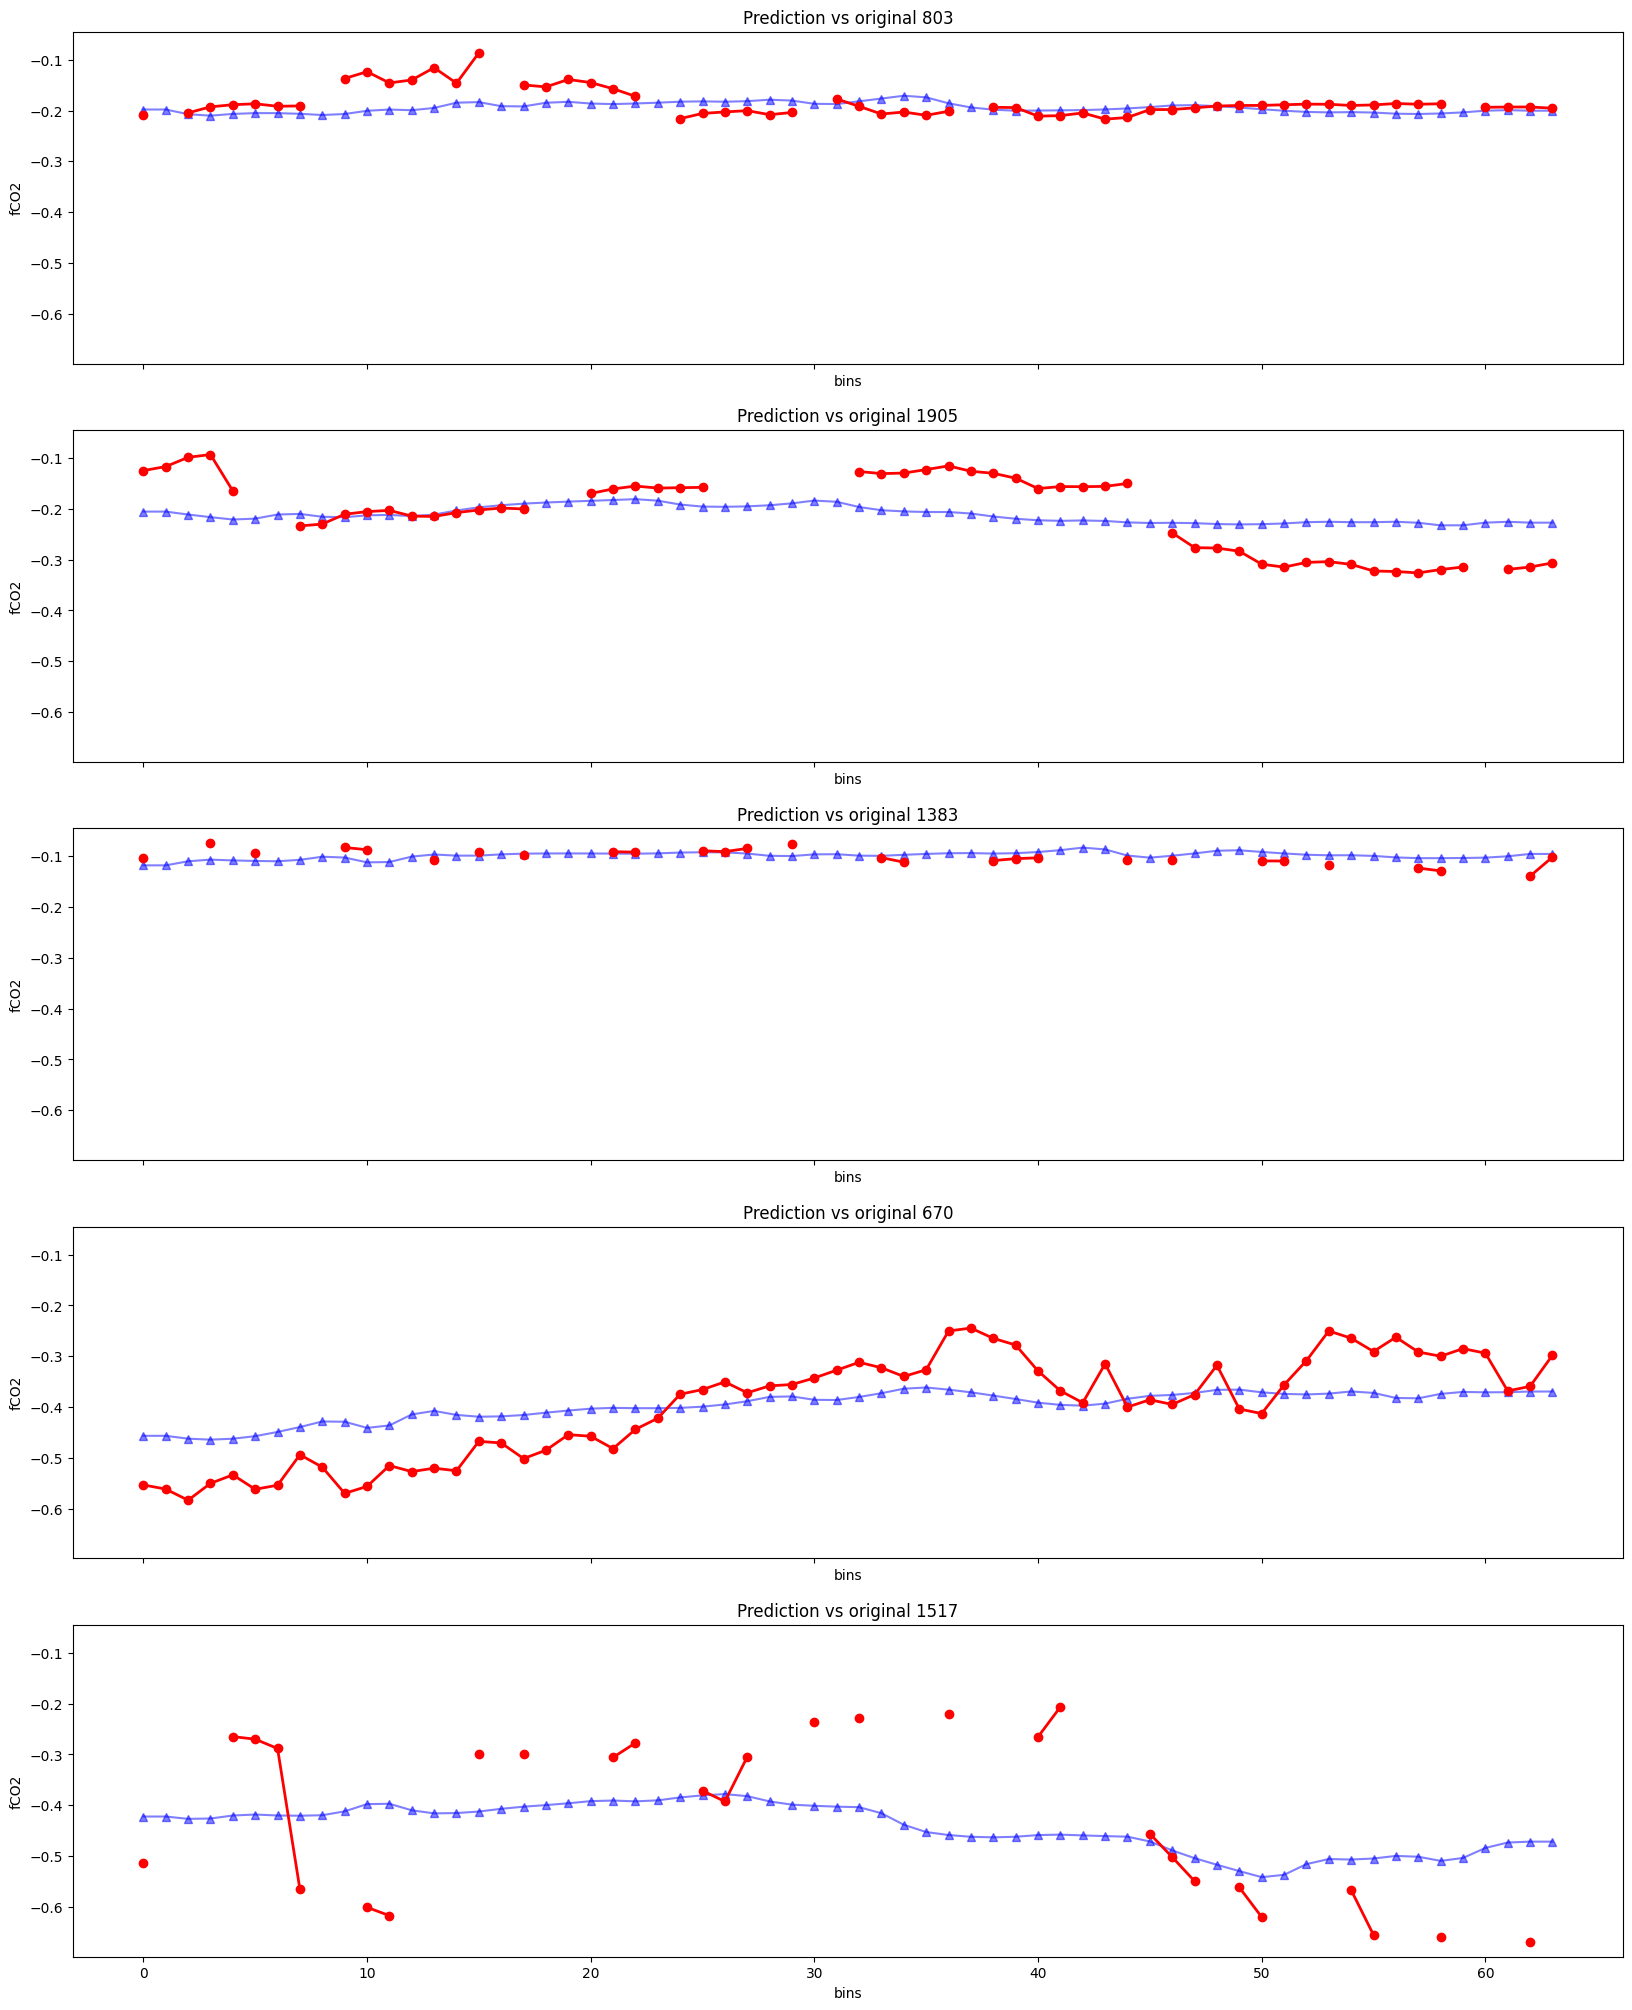

In [122]:
plot_preds(train_preds, train_ds_baseline[:3000], np.random.choice(np.arange(3000), size=5, replace=False))

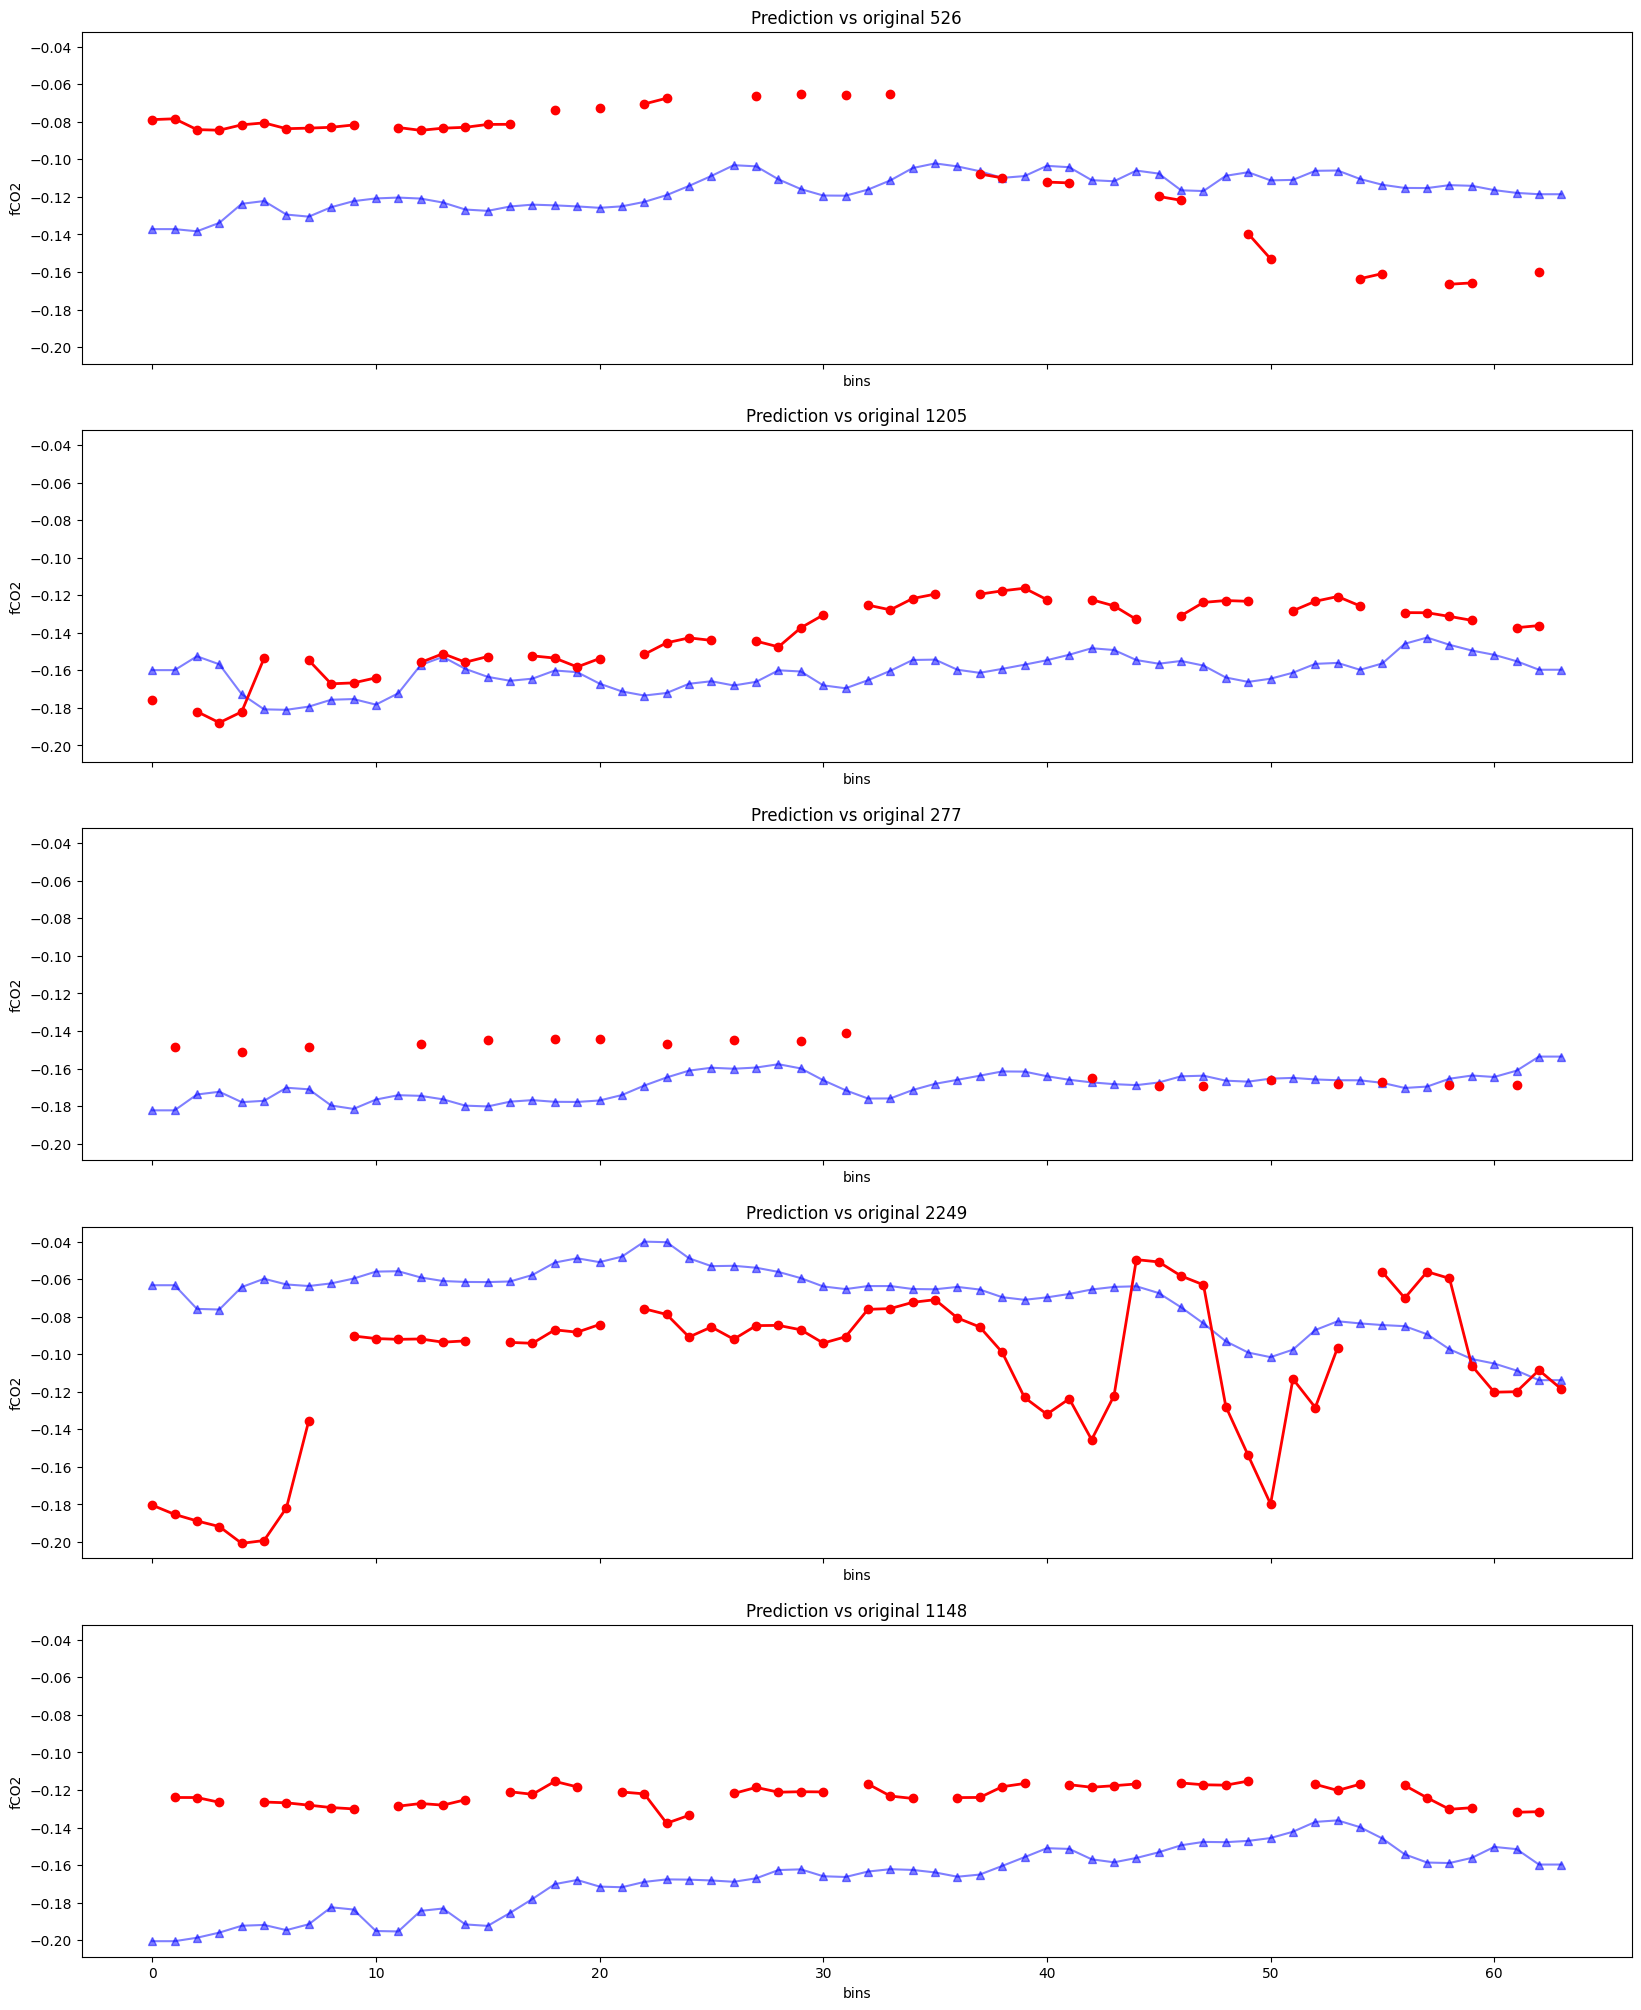

In [123]:
plot_preds(val_preds, val_ds_baseline[:3000], np.random.choice(np.arange(3000), size=5, replace=False))

In [83]:
np.sqrt(0.5)

np.float64(0.7071067811865476)

In [84]:
np.sqrt(0.5) * 31

np.float64(21.920310216782976)

In [85]:
(train_maxs[0] - train_mins[0]) / 2

445.7239532470703

In [37]:
l = 0.0038
np.sqrt(l) * (train_maxs[0] - train_mins[0]) / 2

np.float64(27.476269788549295)